In [1]:
import os
import sys
import pyspark as ps
import warnings
from pyspark.sql import SQLContext
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

try:
    # create SparkContext on all CPUs available: in my case I have 4 CPUs on my→laptop
    sc = ps.SparkContext('local[*]')
    #sqlContext = SQLContext(sc)
    print("Just created a SparkContext")
except ValueError:
    warnings.warn("SparkContext already exists in this scope")

Just created a SparkContext


/home/lplab/anaconda3/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


In [2]:
import unittest
import sys

class TestRdd(unittest.TestCase):
    def test_take(self):
        input = sc.parallelize([1,2,3,4])
        self.assertEqual([1,2,3,4], input.take(4))

        
def run_tests():
    suite = unittest.TestLoader().loadTestsFromTestCase( TestRdd )
    unittest.TextTestRunner(verbosity=1,stream=sys.stderr).run( suite )

run_tests()

.
----------------------------------------------------------------------
Ran 1 test in 0.706s

OK


In [3]:
help(sc)

Help on SparkContext in module pyspark.context object:

class SparkContext(builtins.object)
 |  SparkContext(master: Union[str, NoneType] = None, appName: Union[str, NoneType] = None, sparkHome: Union[str, NoneType] = None, pyFiles: Union[List[str], NoneType] = None, environment: Union[Dict[str, Any], NoneType] = None, batchSize: int = 0, serializer: 'Serializer' = PickleSerializer(), conf: Union[pyspark.conf.SparkConf, NoneType] = None, gateway: Union[py4j.java_gateway.JavaGateway, NoneType] = None, jsc: Union[py4j.java_gateway.JavaObject, NoneType] = None, profiler_cls: Type[pyspark.profiler.BasicProfiler] = <class 'pyspark.profiler.BasicProfiler'>, udf_profiler_cls: Type[pyspark.profiler.UDFBasicProfiler] = <class 'pyspark.profiler.UDFBasicProfiler'>, memory_profiler_cls: Type[pyspark.profiler.MemoryProfiler] = <class 'pyspark.profiler.MemoryProfiler'>)
 |  
 |  Main entry point for Spark functionality. A SparkContext represents the
 |  connection to a Spark cluster, and can be used

In [6]:
import json

fields = ['product_id',
          'user_id',
          'score',
          'time']

fields2 = ['product_id',
           'user_id',
           'review',
           'profile_name',
           'helpfulness',
           'score',
           'time']

fields3 = ['product_id',
           'user_id',
           'time']

fields4 = ['user_id',
           'score',
           'time']

def validate(line):
    for field in fields2:
        if field not in line: return False
    return True

reviews_raw = sc.textFile('movies.json')

reviews = reviews_raw.map(lambda line: json.loads(line)).filter(validate)
reviews.cache()

PythonRDD[9] at RDD at PythonRDD.scala:53

In [7]:
reviews.take(1)

[{'user_id': 'A141HP4LYPWMSR',
  'product_id': 'B003AI2VGA',
  'review': 'Synopsis: On the daily trek from Juarez, Mexico to El Paso, Texas an ever increasing number of female workers are found raped and murdered in the surrounding desert. Investigative reporter Karina Danes (Minnie Driver) arrives from Los Angeles to pursue the story and angers both the local police and the factory owners who employee the undocumented aliens with her pointed questions and relentless quest for the truth.<br /><br />Her story goes nationwide when a young girl named Mariela (Ana Claudia Talancon) survives a vicious attack and walks out of the desert crediting the Blessed Virgin for her rescue. Her story is further enhanced when the "Wounds of Christ" (stigmata) appear in her palms. She also claims to have received a message of hope for the Virgin Mary and soon a fanatical movement forms around her to fight against the evil that holds such a stranglehold on the area.<br /><br />Critique: Possessing a life

In [10]:
num_movies = reviews.groupBy(lambda entry: entry['product_id']).count()
num_users = reviews.groupBy(lambda entry: entry['user_id']).count()
num_entries = reviews.count()
print (str(num_entries) + " reviews of " + str(num_movies) + " movies by " +str(num_users) + " different people.")

50000 reviews of 1539 movies by 36409 different people.


In [33]:
#Suggestion_users= reviews.filter(lambda entry: entry['user_id'])
#for review in Suggestion_users.collect():

r1 = reviews.map(lambda r: ((r['product_id'],), 1))
avg3 = r1.mapValues(lambda x: (x, 1)) \.reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))
# avg3 = avg3.filter(lambda x: x[1][1] > 20 )
# avg3 = avg3.map(lambda x: ((x[1][0]+x[1][1],), x[0])) \.sortByKey(ascending=False)

SyntaxError: unexpected character after line continuation character (<ipython-input-33-8be6f1bf6099>, line 5)

In [22]:
for movie in avg3.take(10):
    print ("http://www.amazon.com/dp/" + movie[1][0] + "WATCHED BY : " + str(movie[0][0]) + " PEOPLE")

NameError: name 'avg3' is not defined

In [25]:
r2 = reviews.map(lambda ru: ((ru['user_id'],), 1))
avg2 = r2.mapValues(lambda x: (x, 1)) \ .reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))
avg2 = avg2.filter(lambda x: x[1][1] > 20 )
avg2 = avg2.map(lambda x: ((x[1][0]+x[1][1],), x[0])) \
.sortByKey(ascending=False )

SyntaxError: unexpected character after line continuation character (<ipython-input-25-edbebbe24329>, line 2)

In [32]:
# Get best and worst rated movies
reviews_by_movie = reviews.map(lambda r: ((r['product_id'],), r['score']))

avg = reviews_by_movie.mapValues(lambda x: (x, 1)) \ .reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))
avg = avg.filter(lambda x: x[1][1] > 20 )
avg = avg.map(lambda x: ((x[1][0]/x[1][1],), x[0]))\.sortByKey(ascending=True)

SyntaxError: unexpected character after line continuation character (<ipython-input-32-073d455f8b06>, line 4)

In [26]:
from datetime import datetime
timeseries_rdd = reviews.map(lambda entry: {'score': entry['score'],
'time': datetime.fromtimestamp(entry['time'])})

   score                time
0    5.0 2003-08-10 05:30:00
1    5.0 2003-08-18 05:30:00
2    5.0 2003-01-14 05:30:00


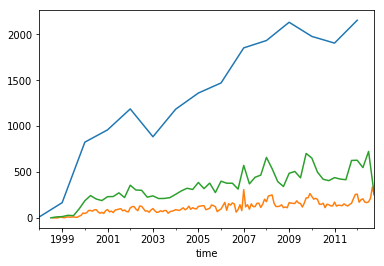

In [27]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
sample = timeseries_rdd.sample(withReplacement=False, fraction=20000.0/num_entries, seed=1134)
timeseries = pd.DataFrame(sample.collect(), 
                          columns=['score', 'time'])

print(timeseries.head(3))
timeseries.score.astype('float64')
#timeseries.time.astype('datetime64')

timeseries.set_index('time', inplace=True)
Rsample = timeseries.score.resample('Y').count()
Rsample.plot()
Rsample2 = timeseries.score.resample('M').count()
Rsample2.plot()
Rsample3 = timeseries.score.resample('Q').count()
Rsample3.plot()

In [29]:
for movie in avg.take(4):
    plt.bar(movie[1][0],movie[0][0])
    plt.title('Histogram of \'AVERAGE RATING OF MOVIE\'')
    plt.xlabel('MOVIE')
    plt.ylabel('AVGRATING')

NameError: name 'avg' is not defined